<a href="https://colab.research.google.com/github/alipk26/proyek-pertama-membuat-model-nlp-dengan-tensorflow/blob/main/proyek_pertama_membuat_model_nlp_dengan_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deklarasi Fungsi

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import drive

#megubah dataset menjadi dataframe

In [ ]:
df = pd.read_csv("/content/kaggle_movie_train.csv")
df.head()

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama


#menghapus genre yang tidak ingin di test

In [ ]:
df = df[~df['genre'].isin(['sci-fi','horror','drama','adventure','action'])]
df['genre'].value_counts()

thriller    6824
comedy      2941
other        270
romance       63
Name: genre, dtype: int64

#menghapus karakter spesial dan menghapus kolom id fan text

In [ ]:
# Menghapus special character di kolom text
df['Text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))
# drop kolom id dan text lama
df = df.drop(['id', 'text'], axis=1)
df.head()

,genre,Text
0,thriller,eady dead maybe even wishing he was INT 2ND FL...
1,comedy,t summa cum laude and all And I m about to lau...
3,thriller,ded by the two detectives INT JEFF S APARTMENT...
5,thriller,breadth of the bluff Gabe pulls out his ancien...
6,thriller,uilding A MAN in pajamas runs out into the rai...


#proses one-hot-encoding.

In [ ]:
genre = pd.get_dummies(df.genre)
df_baru = pd.concat([df, genre], axis=1)
df_baru = df_baru.drop(columns='genre')
df_baru.head()

,Text,comedy,other,romance,thriller
0,eady dead maybe even wishing he was INT 2ND FL...,0,0,0,1
1,t summa cum laude and all And I m about to lau...,1,0,0,0
3,ded by the two detectives INT JEFF S APARTMENT...,0,0,0,1
5,breadth of the bluff Gabe pulls out his ancien...,0,0,0,1
6,uilding A MAN in pajamas runs out into the rai...,0,0,0,1


#mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values

In [ ]:
text = df_baru['Text'].astype(str)
label = df_baru[['comedy', 'other','romance','thriller']].values

#split data training dan data testing

In [ ]:
genre_train, genre_test, label_train, label_test = train_test_split(text, label, test_size = 0.2)

#fungsi Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(genre_train) 
tokenizer.fit_on_texts(genre_test)
 
sekuens_train = tokenizer.texts_to_sequences(genre_train)
sekuens_test = tokenizer.texts_to_sequences(genre_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

#fungsi compile dan tentukan optimizer serta loss function

In [ ]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
Adam(learning_rate=0.00146, name='Adam')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#membuat fungsi callback

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85 and logs.get('val_accuracy')>0.85):
      print("\nAkurasi dan validasi telah mencapai nilai > 85%!")
      self.model.stop_training = True
callbacks = myCallback()

# fungsi fit()

In [ ]:
num_epochs = 50
history = model.fit(padded_train, label_train, epochs=num_epochs, 
                    validation_data=(padded_test, label_test), verbose=1,
                    callbacks=[callbacks])

Epoch 1/50
253/253 [==============================] - 5s 15ms/step - loss: 0.8154 - accuracy: 0.6649 - val_loss: 0.7106 - val_accuracy: 0.6950
Epoch 2/50
253/253 [==============================] - 3s 12ms/step - loss: 0.4681 - accuracy: 0.8396 - val_loss: 0.4188 - val_accuracy: 0.8599
Epoch 3/50
250/253 [============================>.] - ETA: 0s - loss: 0.2457 - accuracy: 0.9329
Akurasi dan validasi telah mencapai nilai > 85%!
253/253 [==============================] - 3s 13ms/step - loss: 0.2455 - accuracy: 0.9330 - val_loss: 0.3329 - val_accuracy: 0.9035


#plot loss

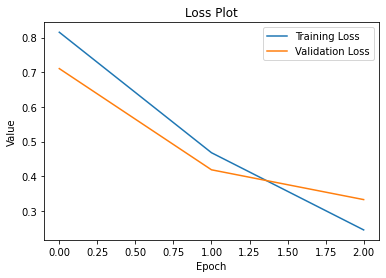

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

#accuracy plot

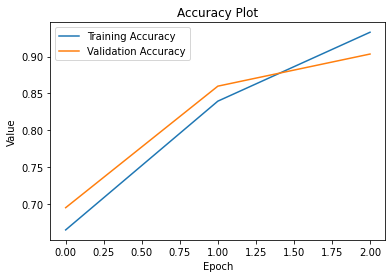

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()